# California Emissions Problem

- California has committed to full zero emissions vehicle emissions by 2035.
- California currently has approximately 30 million light duty vehicles registered. 
- Assume that an average car drives 70% miles in HWFET  and 30% in FTP. 
- Approximately 0.5 million of those vehicles are electric.
- Assume average IC engine vehicle and average battery electric vehicle have the
following same properties:
    - Drag coefficient: C<sub>drag</sub>  = 0.28
    - Frontal area: A<sub>veh</sub> = 2.5 m<sup>2</sup>
    - Rolling resistance coefficient: C<sub>roll</sub> = 0.01
    - Accessory loads:  $ \dot W_{access} = 0.4\  \mathrm{kW_{elec}}  $

- IC Engine:
    - m<sub>veh</sub> = 1600 kg
    - η<sub>elec</sub> = 0.75
    - V<sub>fuel tank</sub> = 50 L gasoline
    - $ \eta_{pt} = a[exp(-\tfrac{\dot w_{veh} [kW]}{\dot w_1}) - exp(-\tfrac{\dot w_{veh} [kW]}{\dot w_2})] \ \mathrm{where}\  a=0.4, \dot w_1=200\ \mathrm{kW}, \dot w_2=17\ \mathrm{kW}, $
- BEV: 
    - m<sub>veh</sub> = 2000 kg
    - η<sub>elec</sub> = 0.94
    - η<sub>motor</sub> = 0.95
    - Open circuit voltage V<sub>cell</sub>: V<sub>0@SOC=100%</sub> = 4.1 V/cell, V<sub>0@SOC=0%</sub> = 3.3 V/cell
    - Cell SOC<sub>0-100%</sub> = 4.0 Ah
    - Cell internal resistance: R<sub>int</sub> = 0.02 Ω
    - n<sub>cell</sub> = 4500 cells


###  Vehicle Properties

In [314]:
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
import hw_utils
import matplotlib_inline
from scipy.integrate import solve_ivp

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

veh_common_props = dict(
    C_drag=0.28,
    A_front=2.5,
    C_roll_0=0.01,
    Wdot_access=400,
    # To be filled in later
    Wdot_drag=[[], []],
    Wdot_roll=[[], []],
    Wdot_accel=[[], []],
    Wdot_access_vec=[[], []],
    Wdot=[[], []],
    x=[[], []],
    E_veh=[[], []],
    E_fuel=[[], []],
    kmperliter=[[], []],
    mpg=[[], []],
)


# wdot_veh in kW
def eta_ice_pt(wdot_veh):
    return 0.4 * (np.exp(-wdot_veh / 200) - np.exp(-wdot_veh / 17))


vehicle_ice = dict(
    **copy.deepcopy(veh_common_props), mass=1600, eta_elec=0.75, eta_pt=eta_ice_pt
)


# wdot_veh in kW
def eta_bev_pt(wdot_veh):
    return 0.95  # just motor efficiency


vehicle_bev = dict(
    **copy.deepcopy(veh_common_props), mass=2000, eta_elec=0.94, eta_pt=eta_bev_pt
)

# constants
G = 9.81  # m/s^2
energydensity_fuel = 34.2  # gasoline energy density (in MJ/l)

# ambient air conditions
ambient = dict(
    v_air=0,  # ambient wind velocity where negative is headwind  (in m/s)
    rho=1.2,  # hardcoding in air density near sea level [kg/m^3]
)

mps_per_kph = 0.2777777  # 1kph = 0.27777777 mps

### Driving Schedules

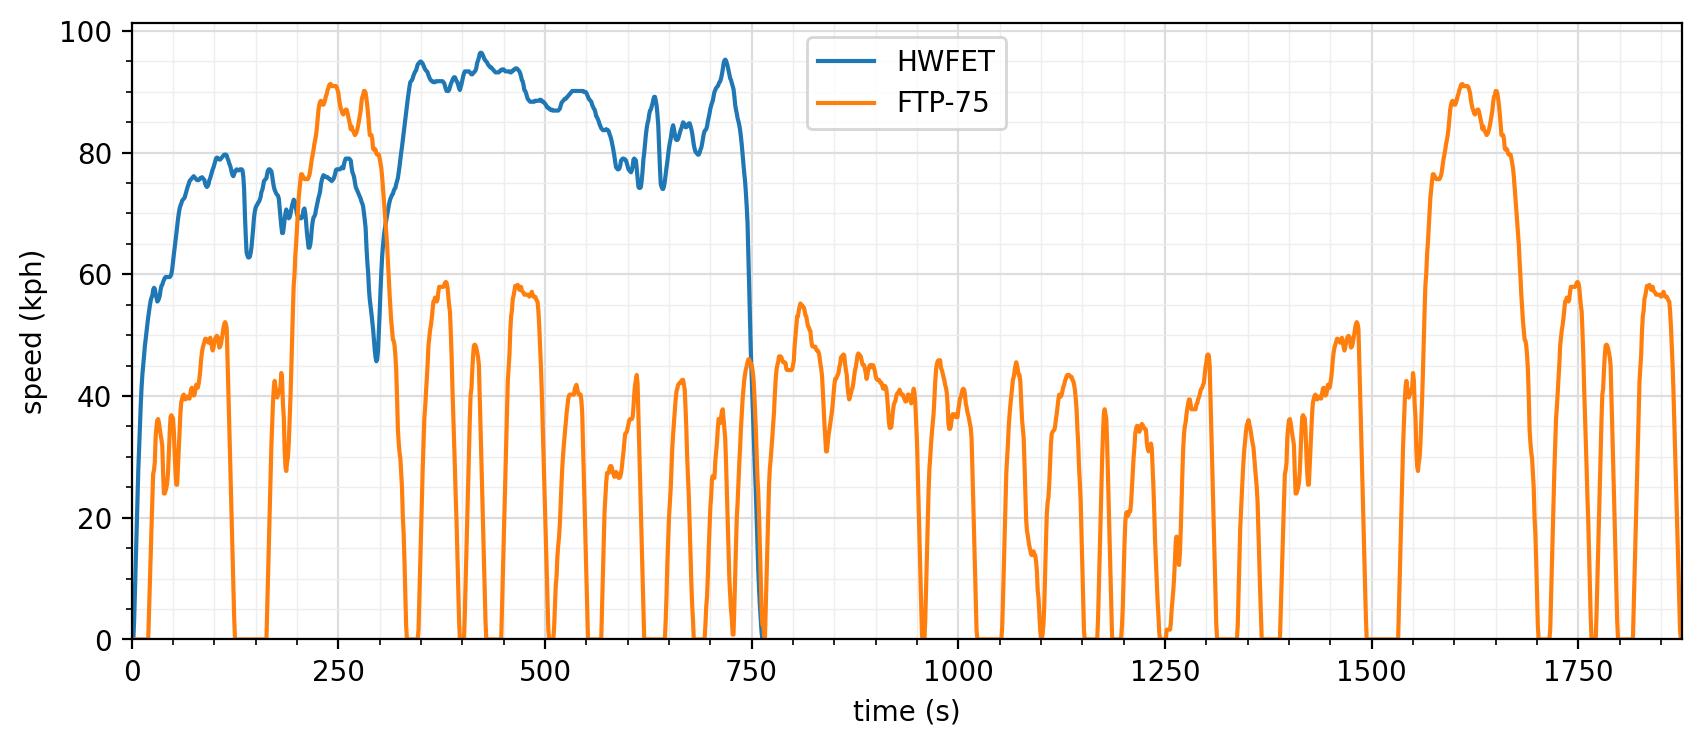

In [315]:
hwfet_schedule = pd.read_csv("./hw2_hwfet.csv", usecols=[0, 1])
ftp_schedule = pd.read_csv("./hw2_ftp.csv", usecols=[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(hwfet_schedule["speed (kph)"], label="HWFET")
plt.plot(ftp_schedule["speed (kph)"], label="FTP-75")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("speed (kph)")
plt.xlim(0, 1875)
plt.ylim(0)
hw_utils.nice_grid(plt)

cycle = dict(
    time=[hwfet_schedule["time"].values, ftp_schedule["time"].values],
    mps=[
        hwfet_schedule["speed (kph)"] * mps_per_kph,
        ftp_schedule["speed (kph)"] * mps_per_kph,
    ],
    name=["HWFET", "FTP-75"],
)

### Road Load Calculations

In [316]:
# Function to solve system of 1st-order linear ODEs with oscillatory forcing
def dydt_vehicle(
    t, y, cycle, vehicle, amb, index, cycle_idx
):  # Determine instantaneous values of velocity, acceleration, and road angle.
    dydt = [0] * len(y)
    duration_of_cycle = cycle["time"][cycle_idx]

    v_veh = np.interp(t, duration_of_cycle, cycle["v_veh"])
    dv_vehdt = np.interp(t, duration_of_cycle, cycle["dv_vehdt"])
    alpha = np.pi / 180 * np.interp(t, duration_of_cycle, cycle["alpha"])

    # Set instantaneous velocity
    dydt[index["x"]] = v_veh

    C_roll = vehicle["C_roll_0"]

    traction_force = (
        vehicle["mass"] * (dv_vehdt + G * np.sin(alpha) + C_roll * G * np.cos(alpha))
        + vehicle["C_drag"]
        * vehicle["A_front"]
        * 0.5
        * amb["rho"]
        * (v_veh - amb["v_air"]) ** 2
    )
    Wdot_veh = (max(0, traction_force)) * v_veh + vehicle["Wdot_access"] / vehicle["eta_elec"]

    dydt[index["E_veh"]] = Wdot_veh

    # Determine power train efficiency and instantaneous fuel energy demand rate
    eta = vehicle["eta_pt"](Wdot_veh / 1000)
    dydt[index["E_fuel"]] = Wdot_veh / eta
    return dydt


# Set up indices and intial conditions for solution vector y(t) = [x; Wdot_veh]'
index = dict(x=0, E_veh=1, E_fuel=2)
y_0 = [None] * 3
y_0[index["x"]] = 0
y_0[index["E_veh"]] = 0
y_0[index["E_fuel"]] = 0


def calculate_loads(vehicle):
    for cycle_index, speed in enumerate(cycle["mps"]):
        arr_length = len(speed)
        time = cycle["time"][cycle_index]

        #  driving cycle vehicle velocities [m/s]
        cycle["v_veh"] = speed
        # road angle to horizontal  [deg.]
        cycle["alpha"] = [0] * arr_length
        # Calculate vehicle acceleration and identify times when acceleration is positive, zero for this problem
        cycle["dv_vehdt"] = np.gradient(cycle["v_veh"])

        # Call an ODE integrator to solve for y(t)
        sol = solve_ivp(
            dydt_vehicle,
            [0, time[-1] + 1],
            y_0,
            "RK45",
            time,
            args=(cycle, vehicle, ambient, index, cycle_index),
            rtol=1e-4,
            atol=1e-4,
        )

        vehicle["x"][cycle_index] = sol.y[index["x"]] / 1000
        vehicle["E_veh"][cycle_index] = sol.y[index["E_veh"]] / 1000
        vehicle["E_fuel"][cycle_index] = sol.y[index["E_fuel"]] / 1000
        vehicle["kmperliter"][cycle_index] = [0] * arr_length
        vehicle["kmperliter"][cycle_index] = (
            1000
            * vehicle["x"][cycle_index]
            / (vehicle["E_fuel"][cycle_index] / energydensity_fuel)
        )
        vehicle["mpg"][cycle_index] = 2.35215 * vehicle["kmperliter"][cycle_index]

        #  Allocate memory for vectors for calculating vehicle power requirements
        vehicle["Wdot_drag"][cycle_index] = np.zeros(arr_length)
        vehicle["Wdot_roll"][cycle_index] = np.zeros(arr_length)
        vehicle["Wdot_accel"][cycle_index] = np.zeros(arr_length)

        # Calculate instantaneous power (in kW) to overcome forces on vehicle
        #   and integrate to get total work required (in kWh)
        vehicle["Wdot_drag"][cycle_index] = (
            (
                np.array(
                    vehicle["C_drag"]
                    * vehicle["A_front"]
                    * 0.5
                    * ambient["rho"]
                    * (np.array(cycle["v_veh"]) - ambient["v_air"]) ** 2
                )
            )
            * cycle["v_veh"]
            / 1000
        )

        C_roll = vehicle["C_roll_0"]
        vehicle["Wdot_roll"][cycle_index] = (
            vehicle["mass"]
            * C_roll
            * (G * np.cos(cycle["alpha"]) * cycle["v_veh"] / 1000)
        )
        vehicle["Wdot_accel"][cycle_index] = vehicle["mass"] * (
            np.array([max(0, dv_dt) for dv_dt in cycle["dv_vehdt"]])
            * cycle["v_veh"]
            / 1000
        )
        vehicle["Wdot_access_vec"][cycle_index] = (
            np.ones(arr_length) * vehicle["Wdot_access"] / vehicle["eta_elec"] / 1000
        )
        vehicle["Wdot"][cycle_index] = (
            vehicle["Wdot_drag"][cycle_index]
            + vehicle["Wdot_roll"][cycle_index]
            + vehicle["Wdot_accel"][cycle_index]
            + vehicle["Wdot_access_vec"][cycle_index]
        )

    return vehicle


vehicle_ice = calculate_loads(vehicle_ice)
vehicle_bev = calculate_loads(vehicle_bev)

/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_82901/2466286960.py:72: RuntimeWarning: invalid value encountered in divide
  1000


/opt/homebrew/lib/python3.11/site-packages/matplotlib/ticker.py:2918: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


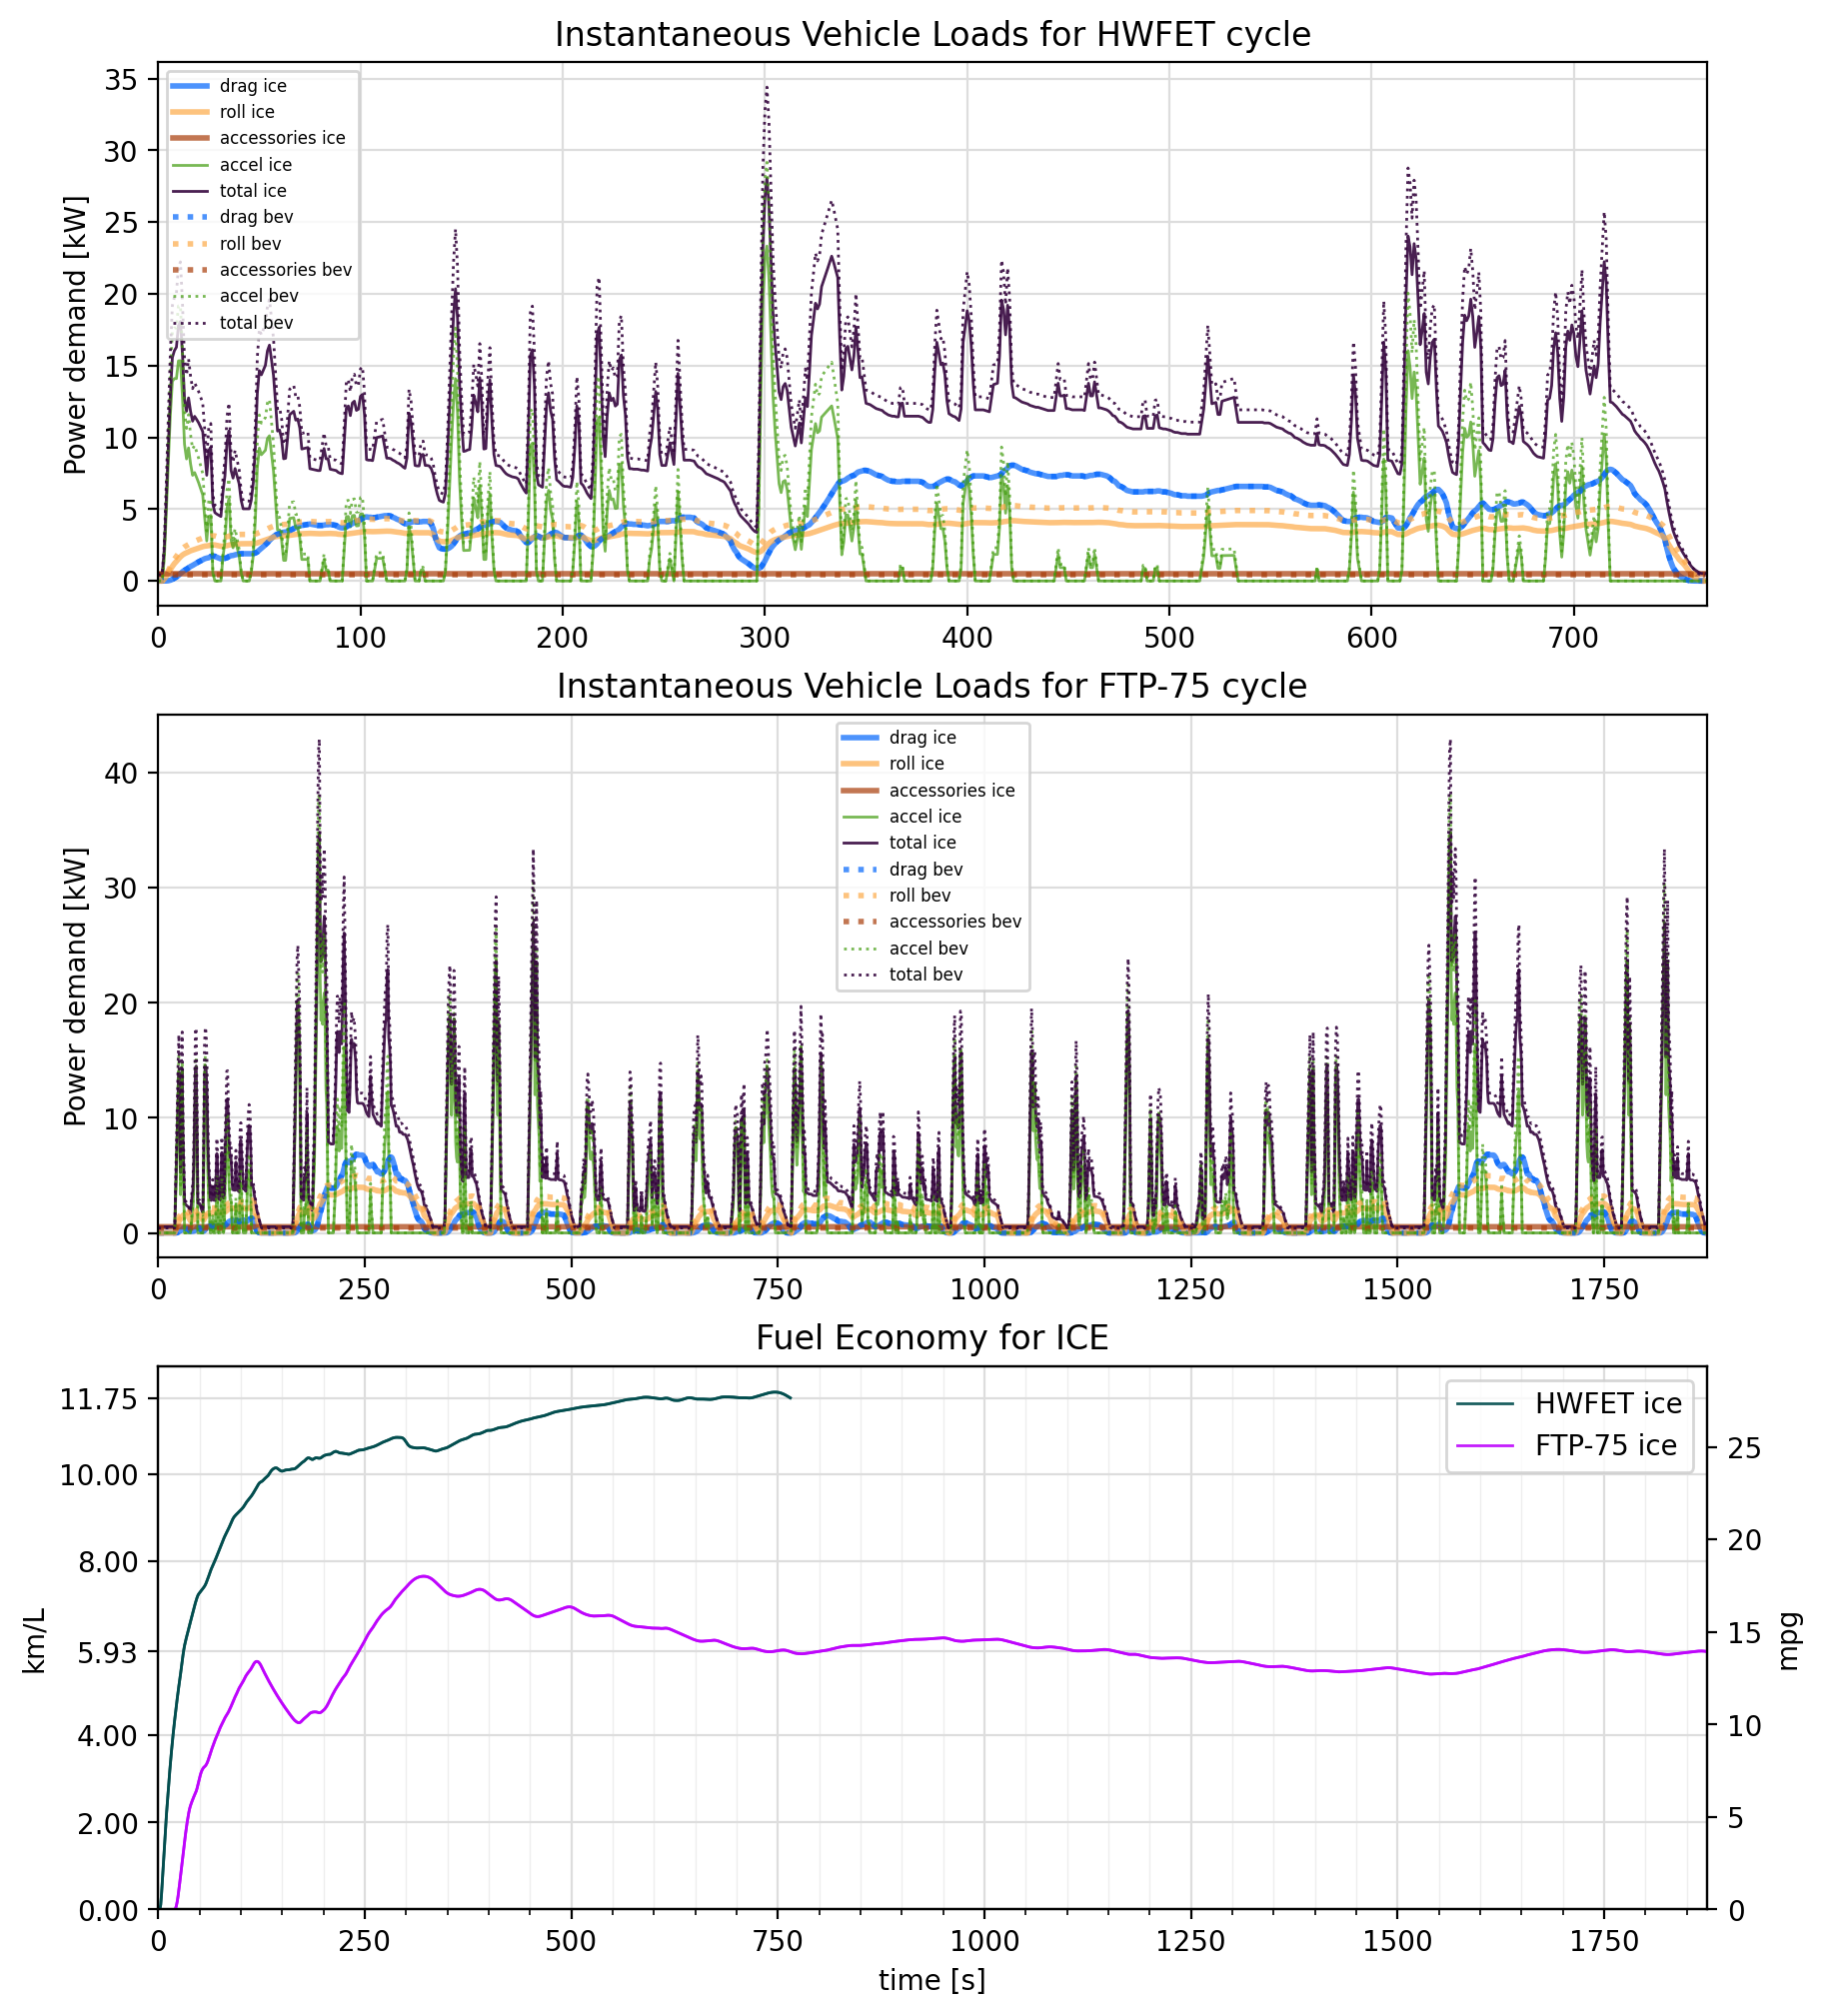

In [317]:
fig, axs = plt.subplots(3, figsize=(10, 12))
mpg_ax = axs[2].twinx()
# Plot instantaneous power required for each load for each cycle
for i in [0, 1]:
    ax = axs[i]
    ax.set_ylabel("Power demand [kW]")
    hw_utils.nice_grid(ax)
    ax.set_xlim(0, len(cycle["time"][i]))
    ax.set_title(f'Instantaneous Vehicle Loads for {cycle["name"][i]} cycle')
    ax.minorticks_off()
    for powerplant, vehicle in [("ice", vehicle_ice), ("bev", vehicle_bev)]:
        ax.plot(
            cycle["time"][i],
            vehicle["Wdot_drag"][i],
            label=f"drag {powerplant}",
            linewidth=2,
            linestyle="dotted" if powerplant == "bev" else "solid",
            alpha=0.7,
            color="xkcd:bright blue",
        )
        ax.plot(
            cycle["time"][i],
            vehicle["Wdot_roll"][i],
            label=f"roll {powerplant}",
            linewidth=2,
            linestyle="dotted" if powerplant == "bev" else "solid",
            alpha=0.7,
            color="xkcd:light orange",
        )
        ax.plot(
            cycle["time"][i],
            vehicle["Wdot_access_vec"][i],
            label=f"accessories {powerplant}",
            linewidth=2,
            linestyle="dotted" if powerplant == "bev" else "solid",
            alpha=0.7,
            color="xkcd:rust",
        )
        ax.plot(
            cycle["time"][i],
            vehicle["Wdot_accel"][i],
            label=f"accel {powerplant}",
            linewidth=1,
            linestyle="dotted" if powerplant == "bev" else "solid",
            alpha=0.7,
            color="xkcd:grass green",
        )
        ax.plot(
            cycle["time"][i],
            vehicle["Wdot"][i],
            label=f"total {powerplant}",
            linewidth=1,
            linestyle="dotted" if powerplant == "bev" else "solid",
            alpha=0.9,
            color="xkcd:dark purple",
        )

    ax.legend(fontsize="6")

    axs[2].plot(
        cycle["time"][i],
        vehicle_ice["kmperliter"][i],
        label=f"{cycle['name'][i]} ice",
        linewidth=1,
        alpha=0.9,
        color=["xkcd:dark teal", "xkcd:bright purple"][i],
    )
    mpg_ax.plot(
        cycle["time"][i],
        vehicle_ice["mpg"][i],
        label=f"{cycle['name'][i]} ice",
        linewidth=1,
        alpha=0.9,
        color=["xkcd:dark teal", "xkcd:bright purple"][i],
    )

axs[2].legend()
hw_utils.nice_grid(axs[2])
axs[2].set_title("Fuel Economy for ICE")
axs[2].set_yticks(
    [vehicle_ice["kmperliter"][0][-1], vehicle_ice["kmperliter"][1][-1], 0, 2, 4, 8, 10]
)
axs[2].set_ylabel("km/L")
mpg_ax.set_ylabel("mpg")
mpg_ax.set_ylim(0)
axs[2].set_xlim(0, len(cycle["time"][1]))
axs[2].set_ylim(0)
axs[2].set_xlabel("time [s]");

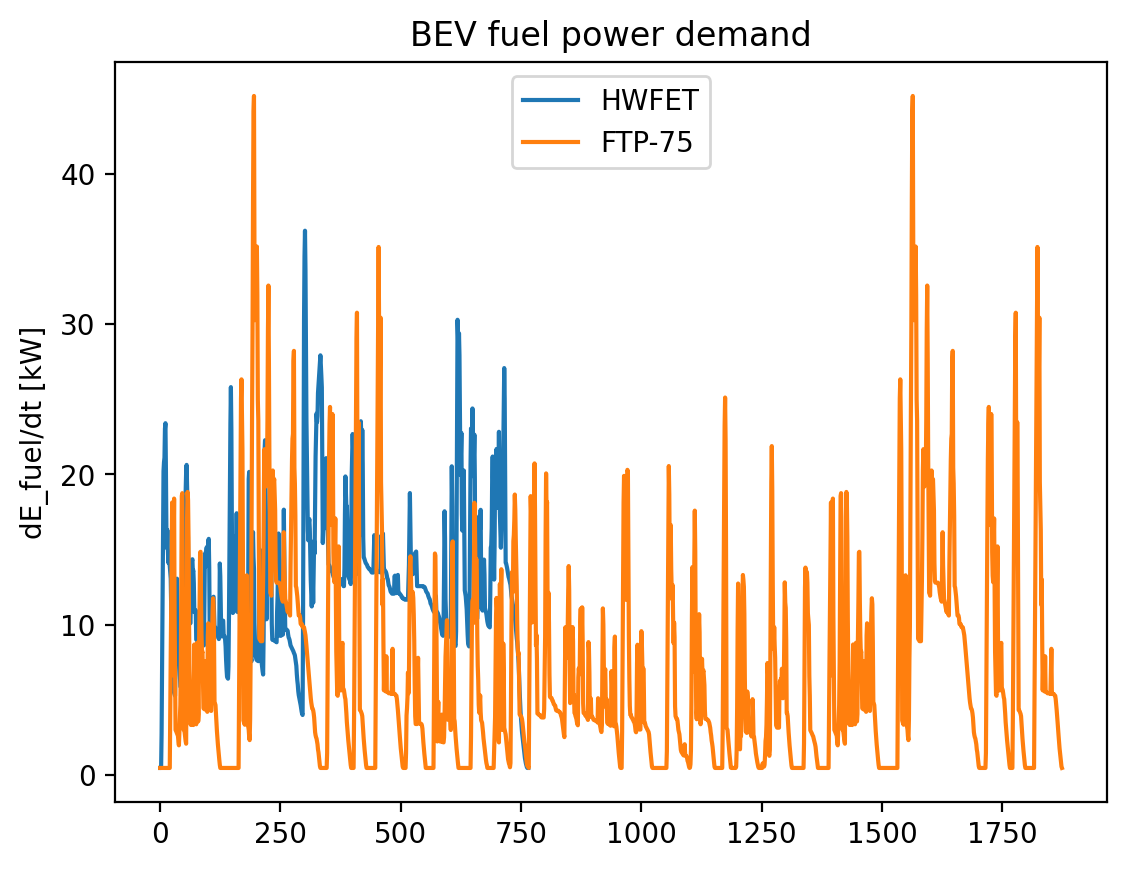

In [318]:
plt.plot(cycle["time"][0], vehicle_bev["Wdot"][0] / 0.95, label="HWFET")
plt.plot(cycle["time"][1], vehicle_bev["Wdot"][1] / 0.95, label="FTP-75")
plt.title("BEV fuel power demand")
plt.ylabel("dE_fuel/dt [kW]")
plt.legend();

Here's how we'll figure out the current at a given instant.

$ V_{cell} = V_{oc}(SOC) - I \cdot R_{int} $

$ \dfrac{\tfrac{P_{batt}}{n_{cell}}}{I} =  V_{oc}(SOC) - I \cdot R_{int}$

$ 0 =  V_{oc}(SOC) - I \cdot R_{int} - \dfrac{\tfrac{P_{batt}}{n_{cell}}}{I} $

$ 0 =  - R_{int} \cdot I^2 + V_{oc}(SOC) \cdot I - \tfrac{P_{batt}}{n_{cell}} $

where, with SOC as a percent,

$ V_{oc}(SOC) = 4.1 - (100 - SOC) \cdot \dfrac{4.1 - 3.3}{100} $

if starting at 100% SOC
	 FTP-75: 3.81 km/%SOC
	 HWFET: 4.6 km/%SOC


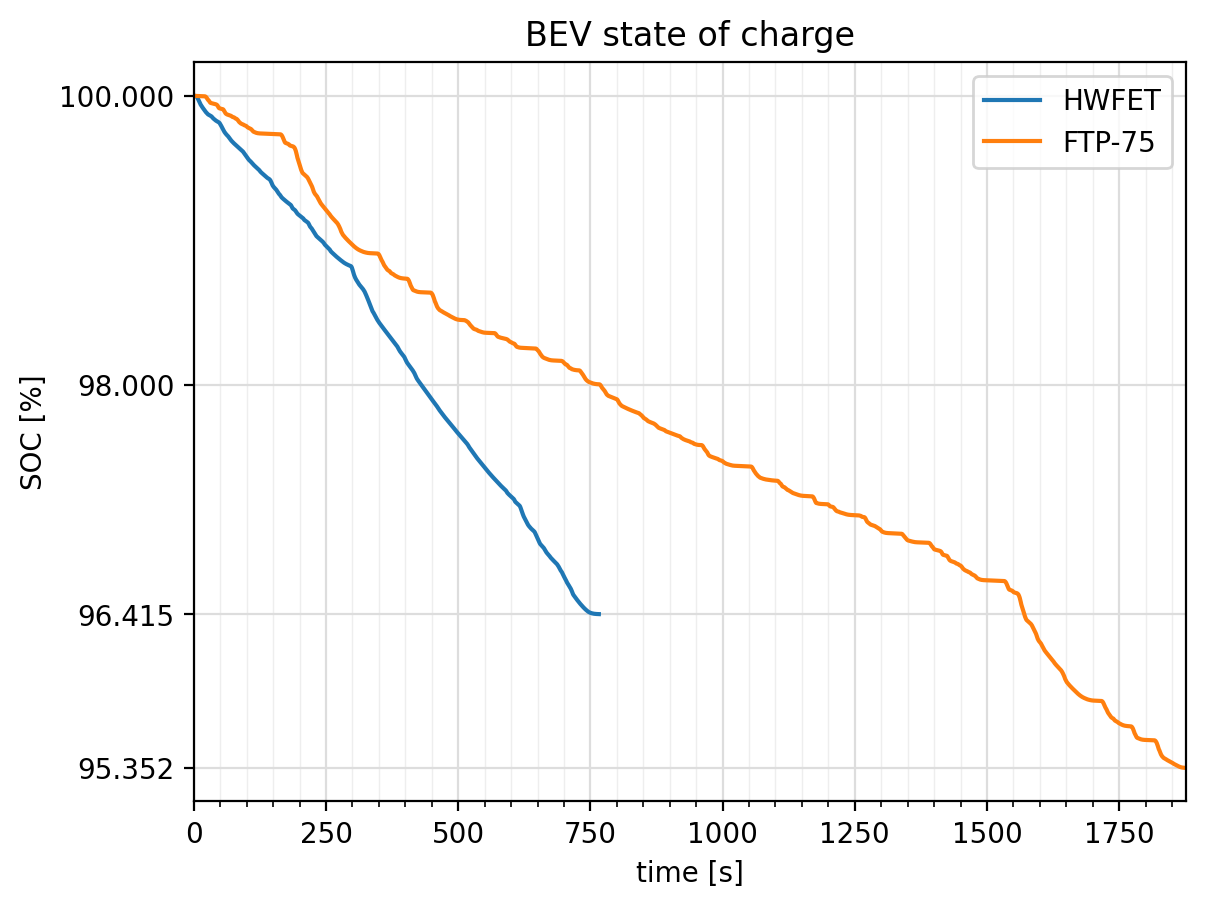

In [319]:
R_int = 0.02
n_cell = 4500
cell_capacity = 4
# To get SOC, must get current at every second
soc = {"HWFET": [100], "FTP-75": [100]}  # SOC in %
for cycle_idx, cycle_name in enumerate(cycle["name"]):
    for t_idx, _t in enumerate(cycle["time"][cycle_idx]):
        soc_now = soc[cycle_name][-1]
        sod_now = 100 - soc_now  # state of discharge right now

        power_batt = vehicle_bev["Wdot"][cycle_idx][t_idx]
        v_oc = 4.1 - sod_now * ((4.1 - 3.3) / 100)

        current = np.min(np.roots([-R_int, v_oc, -power_batt * 1000 / n_cell]))
        amp_hours_used = current * 1 / 3600
        amp_hours_used_as_percent = 100 * amp_hours_used / cell_capacity

        soc[cycle_name] = [*soc[cycle_name], soc_now - amp_hours_used_as_percent]

plt.plot(soc["HWFET"], label="HWFET")
plt.plot(soc["FTP-75"], label="FTP-75")
plt.legend()
plt.title("BEV state of charge")
plt.ylabel("SOC [%]")
plt.xlabel("time [s]")
hw_utils.nice_grid(plt)
plt.yticks([100, 98, soc["HWFET"][-1], soc["FTP-75"][-1]])
plt.xlim(0, len(soc["FTP-75"]))


# From HW 2, we know that the FTP-75 schedule is 17.7km and the HWFET cycle is 16.5km.
print("if starting at 100% SOC")
print(
    "\t FTP-75:", f'{round(17.7 / (soc["FTP-75"][0] - soc["FTP-75"][-1]), 2)} km/%SOC'
)
print("\t HWFET:", f'{round(16.5 / (soc["HWFET"][0] - soc["HWFET"][-1]), 2)} km/%SOC')

In [321]:
soc = {"HWFET": [100], "FTP-75": [100]}  # SOC in %
dist_travelled = {"HWFET": [0], "FTP-75": [0]}  # distance travelled in meters
time_step = 1  # seconds
for cycle_idx, cycle_name in enumerate(cycle["name"]):
    s = 100
    t_idx = 0
    x = 0
    cycle_length = len(cycle["time"][cycle_idx])
    while s > 0:
        # To get SOC, must get current at every second
        # for t_idx, _t in enumerate(cycle["time"][cycle_idx]):
        soc_now = s
        sod_now = 100 - soc_now  # state of discharge right now

        idx_in_cycle = t_idx % cycle_length
        power_batt = vehicle_bev["Wdot"][cycle_idx][idx_in_cycle]
        v_oc = 4.1 - sod_now * ((4.1 - 3.3) / 100)

        current = np.min(np.roots([-R_int, v_oc, -power_batt * 1000 / n_cell]))
        amp_hours_used = current * time_step / 3600
        amp_hours_used_as_percent = 100 * amp_hours_used / cell_capacity

        x = x + cycle["mps"][cycle_idx][idx_in_cycle] * time_step
        s = soc_now - amp_hours_used_as_percent
        t_idx = t_idx + time_step

        soc[cycle_name] = [*soc[cycle_name], s]
        dist_travelled[cycle_name] = [*dist_travelled[cycle_name], x]

bev_ftp_range = dist_travelled["FTP-75"][-1] / 1000
bev_hwfet_range = dist_travelled["HWFET"][-1] / 1000
print("BEV FTP-75 range [km]:", round(bev_ftp_range, 2))
print("BEV HWFET range [km]:", round(bev_hwfet_range, 2))

BEV FTP-75 range [km]: 346.14
BEV HWFET range [km]: 416.58


In [302]:
bev_energy_capacity = (3.7 * cell_capacity * n_cell) / 1000
print("BEV energy capacity [kWh]:", bev_energy_capacity)

print(
    "BEV HWFET fuel economy [km/kWh]:", round(bev_hwfet_range / bev_energy_capacity, 2)
)
print(
    "BEV FTP-75 fuel economy [km/kWh]:", round(bev_ftp_range / bev_energy_capacity, 2)
)

bev_avg_fuel_economy = (
    0.7 * bev_hwfet_range + 0.3 * bev_ftp_range
) / bev_energy_capacity
print(
    "BEV Average fuel economy, assuming 70% miles in HWFET and 30% in FTP [km/kWh]: ",
    round(bev_avg_fuel_economy, 2),
)
print(
    "BEV Average range [km]:",
    round(bev_avg_fuel_economy * bev_energy_capacity, 2),
)

BEV energy capacity [kWh]: 66.6
BEV HWFET fuel economy [km/kWh]: 6.25
BEV FTP-75 fuel economy [km/kWh]: 5.2
BEV Average fuel economy, assuming 70% miles in HWFET and 30% in FTP [km/kWh]:  5.94
BEV Average range [km]: 395.45


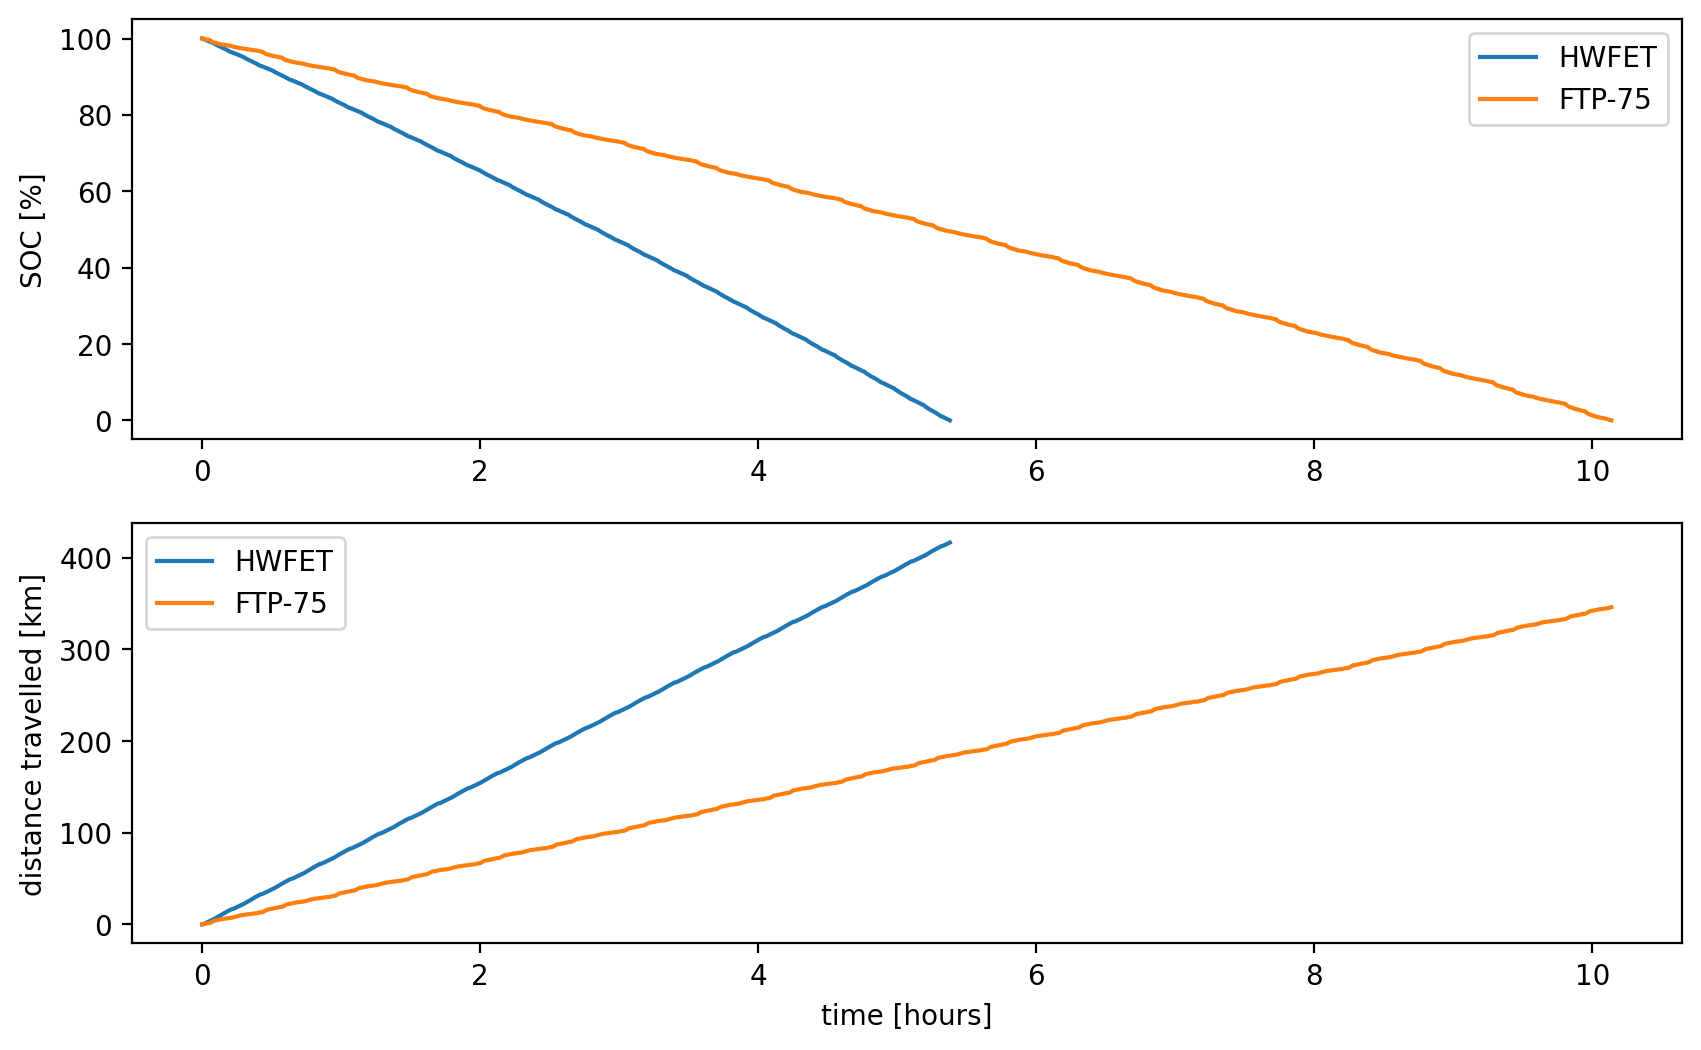

In [312]:
fig, axs = plt.subplots(2, figsize=(10, 6))
for cycle_idx, cycle_name in enumerate(cycle["name"]):
    xx = np.arange(1, len(soc[cycle_name]) + 1) / 3600
    axs[0].plot(xx, soc[cycle_name], label=cycle_name)
    axs[1].plot(xx, np.array(dist_travelled[cycle_name]) / 1000, label=cycle_name)
axs[1].set_xlabel("time [hours]")
axs[0].set_ylabel("SOC [%]")
axs[1].set_ylabel("distance travelled [km]")
axs[0].legend()
axs[1].legend();

### Emissions Calculations

According to Canada's department of natural resources, 2.3kg CO<sub>2</sub> are emitted per L of gasoline.

In [331]:
tank_size = 50  # L

emissions_per_liter_gasoline = 2.3  # kg
emissions_per_tank = emissions_per_liter_gasoline * tank_size


ice_avg_fuel_economy = (
    0.7 * vehicle_ice["kmperliter"][0][-1] + 0.3 * vehicle_ice["kmperliter"][1][-1]
)
print("ICE average fuel economy [km/L]:", round(ice_avg_fuel_economy, 2))
print("ICE range [km]:", round(ice_avg_fuel_economy * tank_size, 2))
print("ICE CO2 emissions per tank [kg]:", round(emissions_per_tank, 2))
print("")

print(
    "ICE CO2 emissions per km [kg]:",
    round(ice_avg_fuel_economy * tank_size / emissions_per_tank, 2),
)

# Found a source that says California emissions per kWh are about 0.23 kg CO2 / kWh
# Assuming charging is 90% efficient
bev_co2 = bev_avg_fuel_economy * 0.23 * 1 / 0.9
print("BEV CO2 emissions per km [kg]:", round(bev_co2, 2))

ICE average fuel economy [km/L]: 10.01
ICE range [km]: 500.25
ICE CO2 emissions per tank [kg]: 115.0

ICE CO2 emissions per km [kg]: 4.35
BEV CO2 emissions per km [kg]: 1.52


# Fuel Cell HDV


In [332]:
eta_motor = 0.9
eta_bop = 0.92
eta_elec = 0.95


def eta_h2_powertrain(wdot_veh):
    return eta_motor * eta_bop * eta_elec


vehicle_fcev_hdv = dict(
    mass=28000,
    C_drag=0.65,
    A_front=11.5,
    C_roll_0=0.005,
    Wdot_access=500,
    eta_elec=eta_elec,
    eta_pt=eta_h2_powertrain,
    # To be filled in later
    Wdot_drag=[[], []],
    Wdot_roll=[[], []],
    Wdot_accel=[[], []],
    Wdot_access_vec=[[], []],
    Wdot=[[], []],
    x=[[], []],
    E_veh=[[], []],
    E_fuel=[[], []],
    kmperliter=[[], []],
    mpg=[[], []],
)

vehicle_fcev_hdv = calculate_loads(vehicle_fcev_hdv)
fig, axs = plt.subplots(2, figsize=(10, 6))
axs[0].plot(vehicle_fcev_hdv["Wdot"])

/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_82901/2466286960.py:72: RuntimeWarning: invalid value encountered in divide
  1000
